### In this document I will create the Mask Detection CNN model that will be used in the project. 

## Data Preproccessing : 

In [106]:
import os
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (160,160)
BATCH_SIZE = 32
EPOCHS = 20
train_path = '../dataset/train'
test_path = '../dataset/test'

#### rescaling the image pixels to [[0 , 1]] values, since neural networks work better with these values. (Normalization)

In [119]:
train_generator = ImageDataGenerator(rescale=1./255, validation_split=0.15, channel_shift_range=15,brightness_range=[0.4,1.3])
test_generator = ImageDataGenerator(rescale=1./255)

In [120]:
train_ds = train_generator.flow_from_directory(
    train_path,
    subset = "training",
    seed = 42,
    target_size = IMG_SIZE,
    shuffle=True,
    batch_size = BATCH_SIZE
)
valid_ds = train_generator.flow_from_directory(
    train_path,
    subset = "validation",
    seed = 42,
    target_size = IMG_SIZE,
    shuffle=True,
    batch_size = BATCH_SIZE
)
print(train_ds.class_indices)

Found 3218 images belonging to 2 classes.
Found 567 images belonging to 2 classes.
{'with_mask': 0, 'without_mask': 1}


## Building the Model :

In [202]:
model = keras.Sequential()
# Convolutional Layers
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape = (IMG_SIZE[0],IMG_SIZE[1],3)))
model.add(keras.layers.MaxPooling2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(2,2))
model.add(keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(2,2))
# Fully Connected layers
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 158, 158, 32)      896       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 77, 77, 64)        18496     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 36, 36, 128)       73856     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 18, 18, 128)       0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 41472)           

(Monitoring our training period with accuracy callbacks, we save the model's best epoch and stop early if the val_loss have not deccreased after 5 epochs.)

In [115]:
from tensorflow.keras.callbacks import EarlyStopping
earlyStop_Max=EarlyStopping(monitor='val_loss', mode='min',verbose=1,patience=5,restore_best_weights=True)
checkpoint_best = tf.keras.callbacks.ModelCheckpoint("maskModel_v0.h5",
                                                    save_best_only=True,
                                                    monitor='val_accuracy',
                                                    mode='max')

In [122]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

### Training the Model :

In [38]:
history = model.fit(train_ds,epochs=EPOCHS,validation_data=valid_ds,callbacks=[earlyStop_Max,checkpoint_best])

Epoch 1/10
101/101 [==============================] - 77s 767ms/step - loss: 0.3622 - accuracy: 0.8486 - val_loss: 0.4049 - val_accuracy: 0.8587
Epoch 2/10
101/101 [==============================] - 77s 759ms/step - loss: 0.1975 - accuracy: 0.9316 - val_loss: 0.1535 - val_accuracy: 0.9417
Epoch 3/10
101/101 [==============================] - 74s 733ms/step - loss: 0.1472 - accuracy: 0.9440 - val_loss: 0.1250 - val_accuracy: 0.9558
Epoch 4/10
101/101 [==============================] - 74s 735ms/step - loss: 0.1389 - accuracy: 0.9502 - val_loss: 0.0758 - val_accuracy: 0.9664
Epoch 5/10
101/101 [==============================] - 74s 736ms/step - loss: 0.0833 - accuracy: 0.9711 - val_loss: 0.0853 - val_accuracy: 0.9735
Epoch 6/10
101/101 [==============================] - 75s 742ms/step - loss: 0.0599 - accuracy: 0.9785 - val_loss: 0.0722 - val_accuracy: 0.9735
Epoch 7/10
101/101 [==============================] - 74s 731ms/step - loss: 0.0511 - accuracy: 0.9820 - val_loss: 0.1873 - val_ac

#### Visualizing training period evaluation:

In [43]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

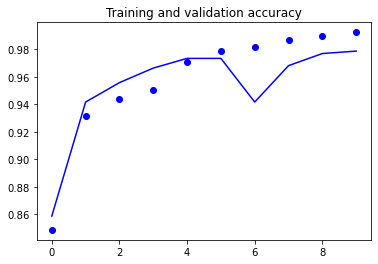

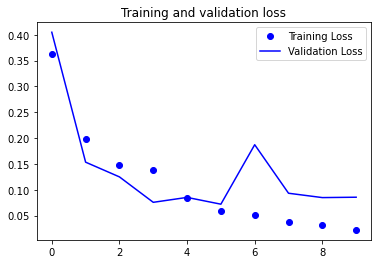

In [44]:
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Model evaluation with test dataset

In [70]:
test_ds = test_generator.flow_from_directory(
    test_path,
    seed = 42,
    target_size = IMG_SIZE,
    shuffle=False,
    batch_size = BATCH_SIZE
)
# defualt shuffle is True, so when feeding it to the network, if shuffle isn't set to False i wont be able to compare it with the test dataset labels, since the predictions will be shuffled.

Found 100 images belonging to 2 classes.


In [139]:
model.evaluate(test_ds)

4/4 [==============================] - 0s 94ms/step - loss: 0.3824 - accuracy: 0.9400


[0.3824100196361542, 0.9399999976158142]

#### Overall we got :
validation accuracy: 0.9788

train accuracy: 0.9925

test set accuracy: 0.9400 (small dataset - 100 images)

#### Saving the model:

In [59]:
keras.models.save_model(model,'mask_model_v3.h5')

### Getting the model's predictions on my own pictures:

In [27]:
# settings the classes names
CLASS_NAMES = list(train_ds.class_indices.keys())

In [211]:
model = keras.models.load_model("mask_model_v3.h5")

#### Processing my images, feeding them to the CNN and showing the predictions:

without_mask 99.99524354934692 %
with_mask 100.0 %
without_mask 100.0 %


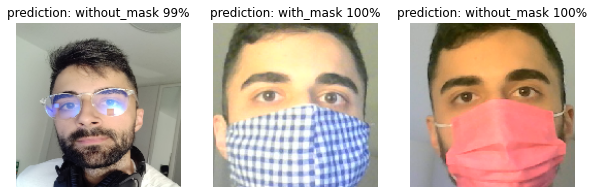

In [272]:
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from keras.preprocessing import image
import numpy as np
# loading mask and no mask images
mask = '../full_face.png'
no_mask = '../no_mask.jpeg'
mask2 = '../full_face_no21.png'
with_mask = image.load_img(no_mask, target_size=IMG_SIZE,color_mode='rgb')
without_mask = image.load_img(mask, target_size=IMG_SIZE,color_mode='rgb')
# visualizing and predicting
pics = [with_mask,without_mask,with_mask2]
plt.figure(figsize=(10, 10))
count = 0
for i in range(3):
    x = image.img_to_array(pics[i])
    x = np.expand_dims(x, axis=0)
    x = x/255.0
    ax = plt.subplot(2, 3,i+1)
    plt.imshow(pics[i])
    plt.axis("off")
    pred = model.predict(x)
    index = np.argmax(pred)
    class_predict = CLASS_NAMES[index]
    precentage = pred[0][index]
    plt.title("prediction: " + class_predict + " " + str(int(precentage*100)) + "%")
    print(class_predict, precentage*100, "%")

### OH, that's no good. the third masked picture is being detected as [100% no mask].
### That means we should tweak our CNN model, and [try again]:

In [247]:
model2 = keras.Sequential()
# Convolutional Layers
model2.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape = (IMG_SIZE[0],IMG_SIZE[1],3)))
model2.add(keras.layers.MaxPooling2D(2,2))
model2.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model2.add(keras.layers.MaxPooling2D(2,2))
model2.add(keras.layers.Conv2D(128, (3,3), activation='relu'))
model2.add(keras.layers.MaxPooling2D(2,2))
# Fully Connected layers
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dropout(0.2))
model2.add(keras.layers.Dense(128, activation='relu'))
model2.add(keras.layers.Dense(2, activation='softmax'))
model2.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 158, 158, 32)      896       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 77, 77, 64)        18496     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 36, 36, 128)       73856     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 18, 18, 128)       0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 41472)           

In [249]:
model2.compile(optimizer=keras.optimizers.Adam(lr=0.001),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [250]:
history3 = model2.fit(train_ds,epochs=EPOCHS,validation_data=valid_ds,callbacks=[earlyStop_Max,checkpoint_best])

Epoch 1/20
101/101 [==============================] - 83s 821ms/step - loss: 0.3432 - accuracy: 0.8639 - val_loss: 0.2875 - val_accuracy: 0.9048
Epoch 2/20
101/101 [==============================] - 85s 840ms/step - loss: 0.1951 - accuracy: 0.9295 - val_loss: 0.1498 - val_accuracy: 0.9524
Epoch 3/20
101/101 [==============================] - 87s 863ms/step - loss: 0.1626 - accuracy: 0.9378 - val_loss: 0.1138 - val_accuracy: 0.9647
Epoch 4/20
101/101 [==============================] - 75s 746ms/step - loss: 0.1501 - accuracy: 0.9422 - val_loss: 0.1016 - val_accuracy: 0.9665
Epoch 5/20
101/101 [==============================] - 74s 733ms/step - loss: 0.1236 - accuracy: 0.9537 - val_loss: 0.0944 - val_accuracy: 0.9700
Epoch 6/20
101/101 [==============================] - 79s 779ms/step - loss: 0.1098 - accuracy: 0.9549 - val_loss: 0.1349 - val_accuracy: 0.9594
Epoch 7/20
101/101 [==============================] - 75s 739ms/step - loss: 0.0898 - accuracy: 0.9705 - val_loss: 0.0967 - val_ac

In [287]:
model2.evaluate(test_ds)

4/4 [==============================] - 0s 106ms/step - loss: 0.1797 - accuracy: 0.9300


[0.17966434359550476, 0.9300000071525574]

#### Second time - Processing my images, feeding them to the CNN and showing the predictions:

without_mask 93.78495812416077 %
with_mask 99.99957084655762 %
with_mask 82.9199492931366 %
with_mask 99.32647943496704 %


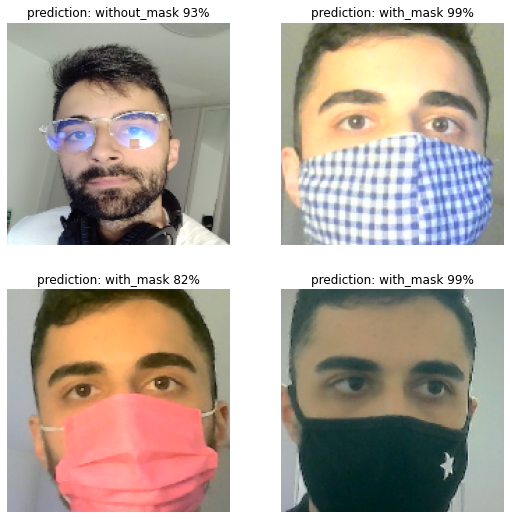

In [267]:
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from keras.preprocessing import image
import numpy as np
# loading mask and no mask images
mask = '../full_face.png'
mask2 = '../full_face_no21.png'
mask3 = '../full_face_no2.png'
no_mask = '../no_mask.jpeg'
with_mask = image.load_img(no_mask, target_size=IMG_SIZE,color_mode='rgb')
without_mask = image.load_img(mask, target_size=IMG_SIZE,color_mode='rgb')
with_mask2 = image.load_img(mask2, target_size=IMG_SIZE,color_mode='rgb')
with_mask3 = image.load_img(mask3, target_size=IMG_SIZE,color_mode='rgb')

# visualizing and predicting
pics = [with_mask,without_mask,with_mask2,with_mask3]
plt.figure(figsize=(9, 9))
count = 0
for i in range(4):
    x = image.img_to_array(pics[i])
    x = np.expand_dims(x, axis=0)
    x = x/255.0
    ax = plt.subplot(2, 2,i+1)
    plt.imshow(pics[i])
    plt.axis("off")
    pred = model2.predict(x)
    index = np.argmax(pred)
    class_predict = CLASS_NAMES[index]
    precentage = pred[0][index]
    plt.title("prediction: " + class_predict + " " + str(int(precentage*100)) + "%")
    print(class_predict, precentage*100, "%")

#### Overall we got :
validation accuracy: [0.9771]

train accuracy: [0.9795]

test set accuracy: [0.9300] (small dataset - 100 images)

The model stopped at epoch 8, since there was no progress for 5 epochs.

## I'll try to train the first model again, this time on a bit tweaked dataset, for 5 epochs, and see the results:

In [304]:
model = keras.models.load_model('mask_model_v3.h5')

In [305]:
model.fit(train_ds,epochs=5,validation_data=valid_ds,callbacks=[earlyStop_Max,checkpoint_best])

Epoch 1/5
101/101 [==============================] - 79s 783ms/step - loss: 0.0191 - accuracy: 0.9963 - val_loss: 0.1126 - val_accuracy: 0.9665
Epoch 2/5
101/101 [==============================] - 75s 744ms/step - loss: 0.0626 - accuracy: 0.9798 - val_loss: 0.0859 - val_accuracy: 0.9735
Epoch 3/5
101/101 [==============================] - 75s 738ms/step - loss: 0.0212 - accuracy: 0.9922 - val_loss: 0.1700 - val_accuracy: 0.9630
Epoch 4/5
101/101 [==============================] - 75s 743ms/step - loss: 0.0178 - accuracy: 0.9938 - val_loss: 0.0683 - val_accuracy: 0.9859
Epoch 5/5
101/101 [==============================] - 75s 743ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0636 - val_accuracy: 0.9841


In [309]:
model.evaluate(test_ds)

4/4 [==============================] - 0s 99ms/step - loss: 0.3448 - accuracy: 0.9300


[0.34482333064079285, 0.9300000071525574]

### Visualizing test set predictions with a Confusion Matrix :

In [ ]:
predictions = model.predict(test_ds)
predict_list = np.argmax(predictions,axis=1)

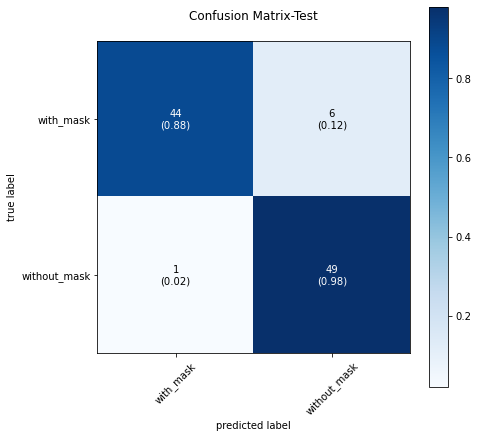

In [84]:
from mlxtend.plotting import plot_confusion_matrix
import tensorflow as tf
confusion=tf.math.confusion_matrix(labels=test_ds.labels,predictions=predict_list)
plot_confusion_matrix(conf_mat=confusion.numpy(), colorbar=True,cmap=plt.cm.Blues,figsize=(7,7),show_normed=True,class_names=CLASS_NAMES)
plt.title("Confusion Matrix-Test")
plt.show()

without_mask 99.99997615814209 %
with_mask 100.0 %
with_mask 97.90920615196228 %
with_mask 99.99948740005493 %


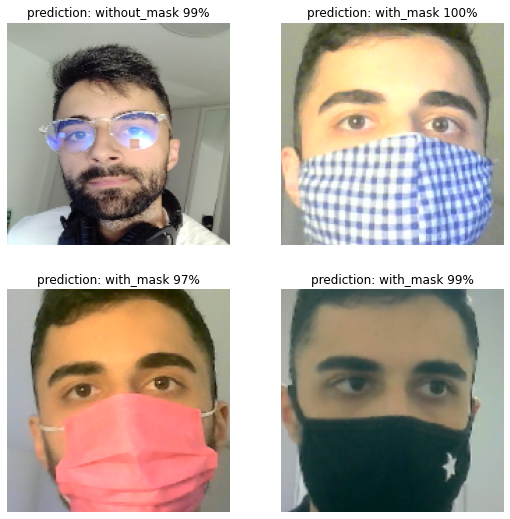

In [312]:
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from keras.preprocessing import image
import numpy as np
# loading mask and no mask images
mask = '../full_face.png'
mask2 = '../full_face_no21.png'
mask3 = '../mask2.png'
no_mask = '../no_mask.jpeg'
without_mask = image.load_img(no_mask, target_size=IMG_SIZE,color_mode='rgb')
with_mask = image.load_img(mask, target_size=IMG_SIZE,color_mode='rgb')
with_mask2 = image.load_img(mask2, target_size=IMG_SIZE,color_mode='rgb')
with_mask3 = image.load_img(mask3, target_size=IMG_SIZE,color_mode='rgb')

# visualizing and predicting
pics = [with_mask,without_mask,with_mask2,with_mask3]
plt.figure(figsize=(9, 9))
count = 0
for i in range(4):
    x = image.img_to_array(pics[i])
    x = np.expand_dims(x, axis=0)
    x = x/255.0
    ax = plt.subplot(2, 2,i+1)
    plt.imshow(pics[i])
    plt.axis("off")
    pred = model.predict(x)
    index = np.argmax(pred)
    class_predict = CLASS_NAMES[index]
    precentage = pred[0][index]
    plt.title("prediction: " + class_predict + " " + str(int(precentage*100)) + "%")
    print(class_predict, precentage*100, "%")

#### Overall:
validation accuracy: [0.9841]

train accuracy: [1.000] (max 100%)

test set accuracy: [0.9300] (small dataset - 100 images)

So far so good, i will work with that model.

In [310]:
keras.models.save_model(model,'maskModel_v3.h5')